In [24]:
from astropy.io import fits
import numpy as np
from glob import glob 
import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.wcs as wcs
from astropy.stats import mad_std
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import binary_dilation
from astropy.modeling import models, fitting
from glob import glob 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import warnings 
sys.path.append('./../modules/')
warnings.filterwarnings('ignore')

from tools_contsub_main import *
from tools_contsub_misc import *
from tools_contsub_units import *
from tools_contsub_plots import *
from tools_contsub_anchoring import * 
from tools_contsub_smoothregrid import * 
from tools_contsub_postprocess import * 

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [25]:
galaxy = 'ngc628c'
galaxy_muse = 'ngc0628'
rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/%s/' %galaxy
rootdir_bp = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/' 
run_cleanup = True

narrowband_filter = 'f658n'
instrument_f555w  = 'acs'
instrument_f65Xn = 'acs'
instrument_f814w = 'acs'

# Take the anchored version, careful of name change in variable
hdu_muse_stars      = get_hdu(rootdir, 'muse/%s_starmask.fits' %galaxy_muse.upper())
hdu_muse_neb        = get_hdu(rootdir, 'muse/%s_nebmask.fits' %galaxy_muse.upper())
hdu_muse            = get_hdu(rootdir, 'muse/%s*_MAPS.fits' %galaxy_muse.upper(), 'all')
hdu_muse_ha         = hdu_muse['HA6562_FLUX']
hdu_muse_f555w      = get_hdu(rootdir, 'hst_contsub/%s_muse_f555w.fits' %galaxy)
hdu_muse_f65Xn      = get_hdu(rootdir, 'hst_contsub/%s_muse_%s.fits' %(galaxy, narrowband_filter))
hdu_muse_f814w      = get_hdu(rootdir, 'hst_contsub/%s_muse_f814w.fits' %galaxy )
hdu_hst_f555w       = get_hdu(rootdir, 'hst_contsub/%s_hst_f555w.fits' %galaxy)
hdu_hst_f65Xn       = get_hdu(rootdir, 'hst_contsub/%s_hst_%s.fits' %(galaxy, narrowband_filter))
hdu_hst_f814w       = get_hdu(rootdir, 'hst_contsub/%s_hst_f814w.fits' %galaxy)
hdu_hst_ha          = get_hdu(rootdir, 'hst_contsub/%s_hst_ha.fits' %galaxy)
hdu_hst_an_cont     = get_hdu(rootdir, 'hst_contsub/%s_hst_%s_an_cont.fits' %(galaxy, narrowband_filter))
hdu_hst_an_contsub  = get_hdu(rootdir, 'hst_contsub/%s_hst_%s_an_contsub.fits' %(galaxy, narrowband_filter))
hdu_muse_contsub    = get_hdu(rootdir, 'hst_contsub/%s_muse_%s_contsub.fits' %(galaxy, narrowband_filter))
hdu_hst_f555w_smre  = get_hdu(rootdir, 'hst_contsub/%s_hst_f555w_smre.fits' %galaxy)
hdu_hst_f65Xn_smre  = get_hdu(rootdir, 'hst_contsub/%s_hst_%s_smre.fits' %(galaxy, narrowband_filter))
hdu_hst_f814w_smre  = get_hdu(rootdir, 'hst_contsub/%s_hst_f814w_smre.fits' %galaxy)
hdu_hst_f555w_an    = get_hdu(rootdir, 'hst_contsub/%s_hst_f555w_an.fits' %galaxy) 
hdu_hst_f65Xn_an    = get_hdu(rootdir, 'hst_contsub/%s_hst_%s_an.fits' %(galaxy, narrowband_filter)) 
# hdu_hst_f65Xn_anf   = get_hdu(rootdir, 'hst_contsub/%s_hst_%s_anf.fits' %(galaxy, narrowband_filter)) 
hdu_hst_f814w_an    = get_hdu(rootdir, 'hst_contsub/%s_hst_f814w_an.fits' %galaxy) 

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628_starmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628-0.92asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst_contsub/ngc628c_muse_f555w.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst_contsub/ngc628c_muse_f658n.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst_contsub/ngc628c_muse_f814w.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst_contsub/ngc628c_hst_f555w.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst_contsub/ngc628c_hst_f658n.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst_contsub/ngc628c_hst_f814w.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hs

In [26]:
ra, dec, size = 24.1721149, 15.7806457, 0.035
hdu_mask = fits.PrimaryHDU(np.isnan(hdu_hst_f555w_smre.data)*1, hdu_hst_f555w_smre.header)
bbox = dict(facecolor='whitesmoke', alpha=0.95, boxstyle='round')

In [27]:
# Covert to units of per arcsec2 (10^-16)

pix_size_hst = (hdu_hst_f555w.header['CD1_1']*u.deg).to('arcsec')
pix_size_muse = (hdu_hst_f555w_smre.header['CD1_1']*u.deg).to('arcsec')

print('HST pixel size: %.2f arcsec' %pix_size_hst.value)
print('MUSE pixel size: %.2f arcsec' %pix_size_muse.value)

pix_area_hst = pix_size_hst**2
pix_area_muse = pix_size_muse**2

factor = 1 # To get from 10^-20 erg/s/cm2/A/arcsec2 to 10^-XX erg/s/cm2/A/arcsec2

hdu_hst_f555w.data = hdu_hst_f555w.data / pix_area_hst.value/factor
hdu_hst_f555w_smre.data = hdu_hst_f555w_smre.data / pix_area_muse.value/factor
hdu_muse_f555w.data = hdu_muse_f555w.data / pix_area_muse.value/factor

hdu_hst_f65Xn.data = hdu_hst_f65Xn.data / pix_area_hst.value/factor
hdu_hst_f65Xn_smre.data = hdu_hst_f65Xn_smre.data / pix_area_muse.value/factor
hdu_muse_f65Xn.data = hdu_muse_f65Xn.data / pix_area_muse.value/factor

hdu_hst_f814w.data = hdu_hst_f814w.data / pix_area_hst.value/factor
hdu_hst_f814w_smre.data = hdu_hst_f814w_smre.data / pix_area_muse.value/factor
hdu_muse_f814w.data = hdu_muse_f814w.data / pix_area_muse.value/factor

HST pixel size: -0.04 arcsec
MUSE pixel size: -0.20 arcsec


In [28]:
def get_anchoring_offset(hdu1, hdu2, hdu3, hdu_stars, filter='', rootdir='./', appdir='hst_contsub/', make_plots=True):

    ### 
    hdu1 = hdu1.copy()
    hdu2 = hdu2.copy()
    hdu3 = hdu3.copy()
    data1 = hdu1.data.copy()
    data2 = hdu2.data.copy()
    data3 = hdu3.data.copy()

    # Mask zeros 
    mask_zero1 = data1==0
    mask_zero2 = data2==0
    data1[(mask_zero1|mask_zero2)] = np.nan
    data2[(mask_zero1|mask_zero2)] = np.nan

    # Mask with starmask 
    mask_stars = hdu_stars.data!=0
    data1[mask_stars] = np.nan
    data2[mask_stars] = np.nan

    data1 = data1.flatten()
    data2 = data2.flatten()

    valid_indices = np.isfinite(data1) & np.isfinite(data2)
    data1 = data1[valid_indices]
    data2 = data2[valid_indices]

    # Mask to only lowest value points 
    x_per = np.percentile(data1, [0.01, 99])
    y_per = np.percentile(data2, [0.01, 99])

    x_mask = (data1>x_per[0])&(data1<x_per[1])
    y_mask = (data2>y_per[0])&(data2<y_per[1])

    data1 = data1[x_mask&y_mask]
    data2 = data2[x_mask&y_mask]

    # Get bins with equal number of points in each bin 
    min_val, max_val = np.percentile(data1, [0, 65]) 
    bin_values = get_bins(data1, data2, 25, equal_spaced=False, min_val=min_val, max_val=max_val)

    # Fit binned data
    model_poly = models.Polynomial1D(degree=1)
    fitter_poly = fitting.LinearLSQFitter() 
    best_fit_poly_bins = fitter_poly(model_poly, bin_values[0], bin_values[1])
    intercept_bins, slope_bins = best_fit_poly_bins.parameters
    
    def func(x, a, b):
        return (a*x) + b
    
    def func_fixed(x, b):
        # For fixed slope
        return x + b

    best_fit_bins, _ = curve_fit(func, bin_values[0], bin_values[1])
    best_fitfixed_bins, _ = curve_fit(func_fixed, bin_values[0], bin_values[1])

    x_fit = np.linspace(np.min(data1), np.max(data1), 10000)
    y_fit = slope_bins * x_fit + intercept_bins
    ###

    # Extract the WCS information from the input and template headers
    wcs1 = wcs.WCS(hdu1.header)
    wcs3 = wcs.WCS(hdu3.header)
    pixscale1 = wcs.utils.proj_plane_pixel_area(wcs1.celestial)
    pixscale3 = wcs.utils.proj_plane_pixel_area(wcs3.celestial)

    pixscale_ratio = (pixscale3 / pixscale1)
    hdu3.data = hdu3.data - (intercept_bins*pixscale_ratio) # HST full resolution 
    hdu2.data = hdu2.data - (intercept_bins) # HST smoothed
    #### 

    output_dict = {'data': (data1, data2), 
                    'binnned_data': (bin_values[0], bin_values[1]), 
                    'fit_data': (x_fit, best_fit_poly_bins(x_fit)), 
                    'fitfixed_data': (x_fit, func_fixed(x_fit, best_fitfixed_bins[0])),
                    'fit_params': (intercept_bins, slope_bins), 
                    'fit_params_fixed': best_fitfixed_bins[0]}

    return(output_dict)

dict_f555w = get_anchoring_offset(hdu_muse_f555w, hdu_hst_f555w_smre, hdu_hst_f555w, hdu_muse_stars, 'f555w')
dict_f65Xn = get_anchoring_offset(hdu_muse_f65Xn, hdu_hst_f65Xn_smre, hdu_hst_f65Xn, hdu_muse_stars, narrowband_filter)
dict_f814w = get_anchoring_offset(hdu_muse_f814w, hdu_hst_f814w_smre, hdu_hst_f814w, hdu_muse_stars, 'f814w')

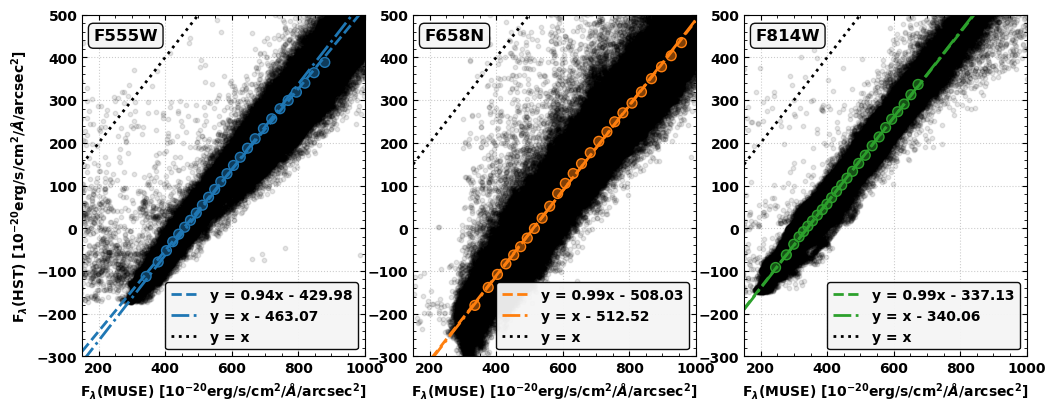

In [29]:
fig = plt.figure(figsize=(10, 3.8))

ax1 = fig.add_subplot(1, 3, 1)
ax3 = fig.add_subplot(1, 3, 2)
ax5 = fig.add_subplot(1, 3, 3)
plt.tight_layout(pad=0.5)

labels  = ['F555W', 'F658N', 'F814W']

def makeplot(ax1, dict, label, c='C0'):

    for ax in [ax1]:

        ax.scatter(dict['data'][0], dict['data'][1], c='black', alpha=0.1, s=10, rasterized=True)
        ax.scatter(dict['binnned_data'][0], dict['binnned_data'][1], fc=c, ec='none', alpha=0.5, s=50, zorder=5)
        ax.scatter(dict['binnned_data'][0], dict['binnned_data'][1], fc='none', ec=c, alpha=1, s=50, zorder=5)
        # ax.plot(dict['binnned_data'][0], dict['binnned_data'][1], c='C0', alpha=1, zorder=5)

        a, b = dict['fit_params'][::-1]

        if b < 0:
            b = np.abs(b)
            label_fit = f'y = %0.2fx - %0.2f' %(a,b) 
        else: 
            label_fit = f'y = %0.2fx + %0.2f' %(a,b) 

        b1 = dict['fit_params_fixed']
        if b1 < 0:
            b1 = np.abs(b1)
            label_fitfixed = f'y = x - %0.2f' %(b1) 
        else: 
            label_fitfixed = f'y = x + %0.2f' %(b1) 


        ax.plot(dict['fit_data'][0], dict['fit_data'][1], color=c, linewidth=2, linestyle='--', label=label_fit)
        ax.plot(dict['fitfixed_data'][0], dict['fitfixed_data'][1], color=c, linewidth=2, linestyle='-.', label=label_fitfixed)
        ax.plot(dict['fit_data'][0], dict['fit_data'][0], color='k', linewidth=2, linestyle=':', label=f'y = x')
        
        ax.grid(True, ls=':', color='k', alpha=0.2, which='major')
    
    ax.text(0.04, 0.925, label, transform=ax1.transAxes, bbox=bbox, fontsize=12)

    ax1.set_xlim([150, 1000])
    ax1.set_ylim([-300, 500])

    ax1.legend(facecolor='whitesmoke', framealpha=0.95, edgecolor='k', loc='lower right')

    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    return(ax1)

makeplot(ax1, dict_f555w, labels[0], c='C0')
makeplot(ax3, dict_f65Xn, labels[1], c='C1')
makeplot(ax5, dict_f814w, labels[2], c='C2')

ax1.set_xlabel('F$_\lambda$(MUSE) [10$^{-20}$erg/s/cm$^2$/$\AA$/arcsec$^2$]')
ax3.set_xlabel('F$_\lambda$(MUSE) [10$^{-20}$erg/s/cm$^2$/$\AA$/arcsec$^2$]')
ax5.set_xlabel('F$_\lambda$(MUSE) [10$^{-20}$erg/s/cm$^2$/$\AA$/arcsec$^2$]')
ax1.set_ylabel('F$_\lambda$(HST) [10$^{-20}$erg/s/cm$^2$/$\AA$/arcsec$^2$]')

fig.savefig('./figs/%s_scatter_anchor.pdf' %galaxy, bbox_inches='tight')  

In [30]:
def get_anchoring_halpha(hdu1, hdu2, hdu3, hdu_neb, filter='', make_plots=True):

    ### 
    hdu1 = hdu1.copy()
    hdu2 = hdu2.copy()
    hdu3 = hdu3.copy()
    data1 = hdu1.data.copy()
    data2 = hdu2.data.copy()
    data3 = hdu3.data.copy()

    # Mask zeros 
    mask_zero1 = data1==0
    mask_zero2 = data2==0
    data1[(mask_zero1&mask_zero2)] = np.nan
    data2[(mask_zero1&mask_zero2)] = np.nan

    # Mask with nebmask 
    mask_neb = hdu_neb.data==-1
    data1[mask_neb] = np.nan
    data2[mask_neb] = np.nan

    valid_indices = np.isfinite(data1) & np.isfinite(data2)
    data1 = data1[valid_indices]
    data2 = data2[valid_indices]

    # Mask to only lowest value points 
    x_per = np.percentile(data1, [0.1, 99.9])
    y_per = np.percentile(data2, [0.1, 99.9])

    x_mask = (data1>x_per[0])&(data1<x_per[1])
    y_mask = (data2>y_per[0])&(data2<y_per[1])

    data1 = data1[x_mask&y_mask]
    data2 = data2[x_mask&y_mask]

    # Get bins with equal number of points in each bin 
    min_val, max_val = np.percentile(data1, [10, 90]) 
    # bin_values = get_bins(data1, data2, 20, equal_spaced=True, min_val=min_val, max_val=max_val)
    bin_values = get_bins(data1, data2, 20, equal_spaced=False, min_val=min_val, max_val=max_val)

    # Fit binned data
    model_poly = models.Polynomial1D(degree=1)
    fitter_poly = fitting.LinearLSQFitter() 
    best_fit_poly_bins = fitter_poly(model_poly, bin_values[0], bin_values[1])
    intercept_bins, slope_bins = best_fit_poly_bins.parameters

    x_fit = np.linspace(-1e3, np.nanmax(data2), 10000)
    y_fit_bins = slope_bins * x_fit + intercept_bins
    ###

    # Extract the WCS information from the input and template headers
    wcs1 = wcs.WCS(hdu1.header)
    wcs3 = wcs.WCS(hdu3.header)
    pixscale1 = wcs.utils.proj_plane_pixel_area(wcs1.celestial)
    pixscale3 = wcs.utils.proj_plane_pixel_area(wcs3.celestial)

    pixscale_ratio = (pixscale3 / pixscale1)
    offset1 = (0 - (intercept_bins*pixscale_ratio)) / slope_bins
    offset2 = (0 - (intercept_bins)) / slope_bins

    output_dict = {'data': (data1, data2), 
                    'binnned_data': (bin_values[0], bin_values[1]), 
                    'fit_data': (x_fit, best_fit_poly_bins(x_fit)), 
                    'fit_params': (intercept_bins, slope_bins)}

    return(output_dict)

dict_ha = get_anchoring_halpha(hdu_muse_ha, hdu_muse_contsub, hdu_hst_ha, hdu_muse_neb, 'an_halpha_neb')

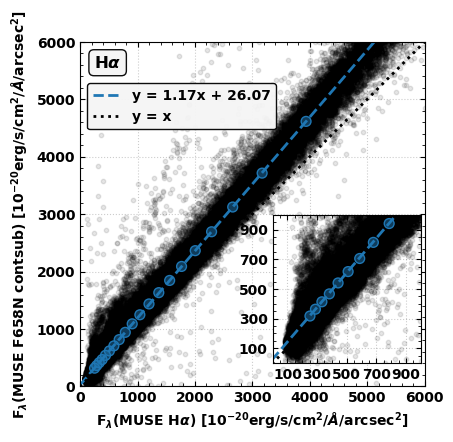

In [31]:
fig = plt.figure(figsize=(4, 4))

ax1 = fig.add_subplot(1, 1, 1)
plt.tight_layout(pad=0.5)

ax2 = fig.add_axes([ax1.get_position().x1-0.38, ax1.get_position().y0+0.08, 0.37, 0.37])

labels  = [r'H$\alpha$']
factor = 1

def makeplot(ax1, ax2, dict, label, c='C0'):

    for ax in [ax1, ax2]:

        ax.scatter(dict['data'][0]*factor, dict['data'][1]*factor, c='black', alpha=0.1, s=10, rasterized=True)
        ax.scatter(dict['binnned_data'][0]*factor, dict['binnned_data'][1]*factor, fc=c, ec='none', alpha=0.5, s=50, zorder=5)
        ax.scatter(dict['binnned_data'][0]*factor, dict['binnned_data'][1]*factor, fc='none', ec=c, alpha=1, s=50, zorder=5)
        # ax.plot(dict['binnned_data'][0], dict['binnned_data'][1], c='C0', alpha=1, zorder=5)

        a, b = dict['fit_params'][::-1]

        if b < 0:
            b = np.abs(b)
            label_fit = f'y = %0.2fx - %0.2f' %(a,b) 
        else: 
            label_fit = f'y = %0.2fx + %0.2f' %(a,b) 

        ax.plot(dict['fit_data'][0]*factor, dict['fit_data'][1]*factor, color=c, linewidth=2, linestyle='--', label=label_fit)
        ax.plot(dict['fit_data'][0]*factor, dict['fit_data'][0]*factor, color='k', linewidth=2, linestyle=':', label=f'y = x')
        
        ax.grid(True, ls=':', color='k', alpha=0.2, which='major')
    
    ax.text(0.04, 0.925, label, transform=ax1.transAxes, bbox=bbox, fontsize=12)

    ax1.legend(facecolor='whitesmoke', framealpha=0.95, edgecolor='k', bbox_to_anchor=(0, 0.8, 0.1, 0.1), loc='upper left')

    # ax1.xaxis.set_minor_locator(AutoMinorLocator())
    # ax1.yaxis.set_minor_locator(AutoMinorLocator())

    return(ax1)

makeplot(ax1, ax2, dict_ha, labels[0])

ax1.set_aspect('equal')
ax2.set_aspect('equal')

# ax1.set_xticks(np.arange(0,9))
# ax1.set_yticks(np.arange(0,9))
ax2.set_xticks(np.arange(1,10,2)*100)
ax2.set_yticks(np.arange(1,10,2)*100)

ax1.set_xlim([0, 6000])
ax1.set_ylim([0, 6000])

ax2.set_xlim([0, 999])
ax2.set_ylim([0, 999])

ax1.set_xlabel(r'F$_\lambda$(MUSE H$\alpha$) [10$^{-20}$erg/s/cm$^2$/$\AA$/arcsec$^2$]')
ax1.set_ylabel(r'F$_\lambda$(MUSE F658N contsub) [10$^{-20}$erg/s/cm$^2$/$\AA$/arcsec$^2$]')

fig.savefig('./figs/%s_scatter_anchor_contsub.pdf' %galaxy, bbox_inches='tight', dpi=150)  